***In this code, I have compared Markov chain Monte Carlo method (MCMC) with rejection sampling method.***

For basic information see
 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://en.wikipedia.org/wiki/Rejection_sampling

A simple Markov chain Monte-Carlo simulation to generate samples from t-distribution with $2$ degrees of freedom
( target distribution ). I have implemented a random walk Metroplois-Hastings algorithm where I have used a uniform distribution on some intervals $(-\delta , \delta)$ to simulate the walks. 

We have two parameters in the simulation: $\delta$ and $x_0$ ( where to start walking ). Since the target distribution has a density which is symmetric about $0$, so it's reasonable to choose $x_0=0$. Moreover we can expect that if $\delta$ is chosen very small, it takes longer ( needs more simulations ) to see a good estimation. Because our target distribution produces samples which are most likely in interval $(-7.5,7.5)$, therefore if $\delta$ is small, we have small jumps at each step and so we need more simulations to make sure the we have enough samples that cover this interval. On the other hand if $\delta$ is very large, it's more likely to have big jumps and so there is a decent chance that acceptance ratio becomes zero for a long sequence of steps and this means we may not update a sample for a while and this affects the accuracy of simulations.

I have shown how the estimation accuracy changes with $\delta$. In the plots, true density is the density of $t$-distribution with $2$ degrees of freedom.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import t,norm,uniform
from matplotlib.offsetbox import AnchoredText
plt.style.use('ggplot')

In [3]:
def Markov_Monte_Carlo(x0, delta, num_samples):
    X = np.zeros(num_samples)  # Samples
    X[0] = x0
    for i in range(1,num_samples):
        r = np.random.uniform(-delta,delta)
        y = X[i-1] + r
        acc_ratio = min(np.log(t.pdf(y,2))-np.log(t.pdf(X[i-1],2)), 0)  # Acceptance ratio
        u = np.random.uniform(0,1)
        if np.log(u) <= acc_ratio:
            X[i] = y
        else:
            X[i] = X[i-1] 
    return X

In [4]:
def MCMC_Plots(x0, delta_vec, num_samples):
    half = len(delta_vec)//2
    fig1 = plt.figure(figsize=(16,6), constrained_layout=True)
    gs1 = fig1.add_gridspec(2,3)
    ax = {}
    for i, delta in enumerate(delta_vec[:half+1]):  
        ax[i] = fig1.add_subplot(gs1[0, i]) 
        samples = Markov_Monte_Carlo(x0, delta, num_samples)
        x = np.linspace(-8,8,num_samples)
        z = t.pdf(x,2)
        ax[i].plot(x, z, label='true density', color='cornflowerblue')
        sns.kdeplot(samples, label='MCMC simulation', color='orchid', ax=ax[i])
        ax[i].legend(fontsize=8)
        at = AnchoredText('$\delta$={}'.format(delta), loc='center left', frameon=True)
        ax[i].add_artist(at)
        ax[0].set_ylabel('Density')
        ax[i].set_xlim([-8,8])
    for i, delta in enumerate(delta_vec[half+1:]):  
        ax[i] = fig1.add_subplot(gs1[1, i]) 
        samples = Markov_Monte_Carlo(x0, delta, num_samples)
        x = np.linspace(-8,8,num_samples)
        z = t.pdf(x,2)
        ax[i].plot(x, z, label='true density', color='cornflowerblue')
        sns.kdeplot(samples, label='MCMC simulation', color='orchid', ax=ax[i])
        ax[i].legend(fontsize=8)
        at = AnchoredText('$\delta$={}'.format(delta), loc='center left', frameon=True)
        ax[i].add_artist(at)
        ax[0].set_ylabel('Density') 
        ax[i].set_xlim([-8,8])

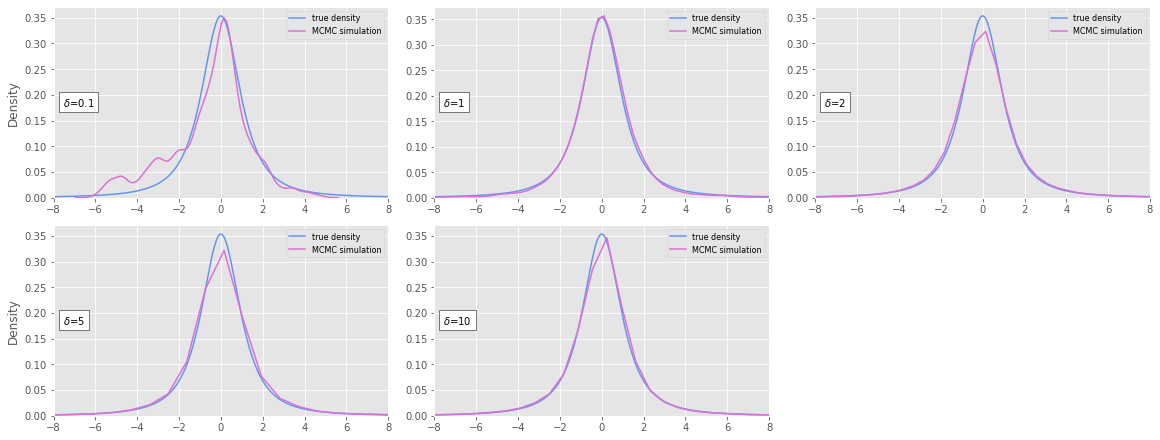

In [19]:
# Experiments        
x0 = 0 
delta_vec = [0.1, 1, 2, 5, 10]
num_samples = 50000

MCMC_Plots(x0, delta_vec, num_samples)

As we can see from the plots after sampling of $50000$ samples, the simulation with $\delta=1$ produces the best estimation and accuracy decreases when $\delta$ is chosen very large. For the smaller values of $\delta$, we need to continue the simulations until we get a close approximation.


In the next cell I have implemented a different method for sampling from t-distribution with $2$ degrees of freedom. This time I have used the rejection sampling method. I have chosen a normal distribution as the candidate density and reject or accept its samples at each step with a specific probability. Here we have 3 parameters: mean and variance of normal distribution ( candidate density ) and $c$ where probability of acceptance is proportional to $1/c$. There are two approaches to deal with parameter $c$. In the first approach $c$ is chosen as $\sup \frac{f(x)}{g(x)}$ where $f$ and $g$ are candidate and target density respectively or alternatively we can start from a initial value for $c$ and update it when we accept a sample. It can be shown that in the second approach after some steps the value of $c$ converges to the value we use for the first approach, i.e. $\sup \frac{f(x)}{g(x)}$, therefore someone might find it more convenient to use the second algorithm in rejection sampling method and not bother themselves finding the supremum of that quotient. 

In the next cell however, I have done an experiment on $4$ different values of $c$ to see how it affects the accuracy of simulations. Since $t$-distribution has mean $0$, so I have chosen $\mu=0$ for the mean of normal distribution. I have also used $3$ different values for $\sigma^2$, variance of normal distribution.

In [6]:
def Quotient(n, mu, sigma, c):
    return t.pdf(n,2)/(c*norm.pdf(n, mu, sigma))

def Rejection_Sampling(mu, sigma, c, num_sim):
    accepted_samples = []
    for i in range(num_sim):  
        u = np.random.uniform(0,1)    
        n = np.random.normal(mu, sigma)    
        if u <= Quotient(n, mu, sigma, c):
            accepted_samples.append(n) 
    return accepted_samples       

In [7]:
def Rejection_Method_Plots(mu, var_vec, c_vec, num_sim):
    fig, ax = plt.subplots(len(c_vec), len(var_vec), figsize=(14,10))
    x = np.linspace(-8,8,num_sim)
    z = t.pdf(x,2)
    for i, c in enumerate(c_vec):
         for j, v in enumerate(var_vec):    
            accepted_samples = Rejection_Sampling(mu, np.sqrt(v), c, num_sim)
            ax[i,j].plot(x, z, label='1', color='cornflowerblue', linewidth=1.5)
            sns.kdeplot(accepted_samples, label='2', color='orchid', ax=ax[i,j], linewidth=1.5)
            ax[i,j].legend(['true density','rejection method'], fontsize=8)
            at = AnchoredText('$\mu=0,\;\sigma^2$={} \n $c$={}'.format(v,c), loc=2, frameon=True)
            ax[i,j].add_artist(at)
            plt.suptitle('Rejection sampling method with different parameters', y=1.05)
            plt.tight_layout()

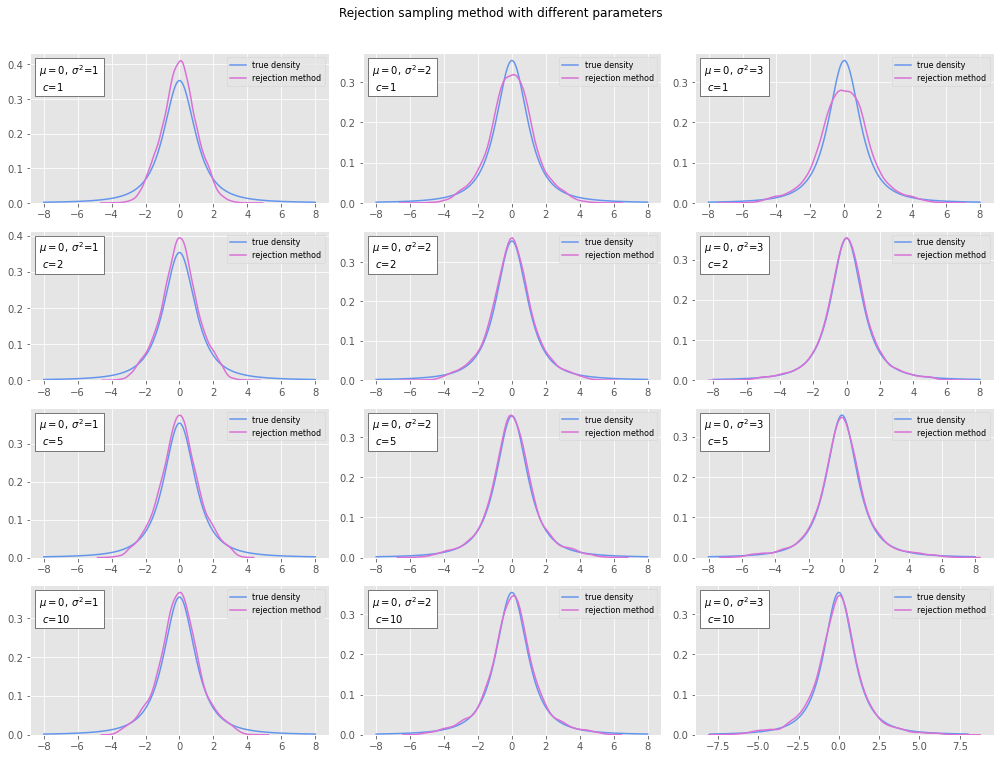

In [27]:
# Experiments
mu = 0  
var_vec = [1, 2, 3]
c_vec = [1, 2, 5, 10]
num_sim = 40000

Rejection_Method_Plots(mu, var_vec, c_vec, num_sim)

In the next cell I have campared rejection method where I have found and fixed $c = \sup \frac{f(x)}{g(x)}$ and the alternative method where I started with an initial value $c_0 =1$ and updated the value of $c$ during the simulation. We can see from the plots that in the second approach, after some steps, $c$ converges to $\sup \frac{f(x)}{g(x)}.$

In [9]:
def Supremum(mu, sigma):
    x = np.linspace(-10,10,100)
    q = norm.pdf(x, mu, sigma) / t.pdf(x,2)
    c = max(q)
    return c

In [10]:
def Rejection_Sampling1(mu, sigma, num_sim):
    """Defines rejection sampling with constant c."""
    c = Supremum(mu, sigma)
    sample1 = []
    for i in range(num_sim):  
        u = np.random.uniform(0,1)    
        n = np.random.normal(mu, sigma)    
        if u <= Quotient(n, mu, sigma, c):
            sample1.append(n) 
    return [c, sample1]

In [11]:
def Rejection_Sampling2(mu, sigma, c0, num_sim):
    
    """Defines rejection sampling with non-constant c."""
    
    c_list = []
    sample2 = []
    c = c0   
    for i in range(num_sim):   
        u = np.random.uniform(0,1)    
        n = np.random.normal(mu, sigma)     
        if u <= Quotient(n, mu, sigma, c):  
            sample2.append(n) 
            c = max(c, norm.pdf(n, mu, sigma)/t.pdf(n,2))  
            c_list.append(c)       
    return [c_list, sample2]    

In [12]:
def Rejection_Comparison_Plots(mu, var_vec, c0, num_sim):
    
    """It compares both methods for rejection sampling."""
    
    fig, ax = plt.subplots(len(var_vec),2, figsize=(12,10))
    x = np.linspace(-8,8,num_sim)
    for i, v in enumerate(var_vec):
        [c, sample1] = Rejection_Sampling1(mu, np.sqrt(v), num_sim)
        [c_list, sample2] = Rejection_Sampling2(mu, np.sqrt(v), c0, num_sim)
        ax[i,0].plot(x, t.pdf(x,2), label='true density', color='black')
        sns.kdeplot(sample1, label='first approach', color='cornflowerblue', ax=ax[i,0])
        sns.kdeplot(sample2, label='alternative method', color='orchid', ax=ax[i,0])
        ax[0,0].set_title('KDE plots')
        ax[i,0].legend(fontsize=10)
        ax[-1,0].set_xlabel('x', fontsize=14)
        ax[i,0].set_xlim([-8,8])
        ax[i,0].text(-6,0.2,'Candidate density:\n$\mu=0,\;\sigma^2$={}'.format(v))
        ax[i,1].axhline(y=c, label='4', color='r', linestyle='--', alpha=0.6)
        ax[i,1].plot(np.arange(len(c_list)), c_list, label='5', color='b', alpha=0.6)
        ax[0,1].set_title('Plots for $c$', fontsize=12)
        ax[i,1].legend(['$c$ in the first approach','$c$ in the second approach'], fontsize=10)
        ax[-1,1].set_xlabel('steps', fontsize=14)
        ax[i,1].set_xlim(0,50)
        plt.suptitle('Rejection sampling method with fixed $c$ and its alternative', y=1.05)
        plt.tight_layout()

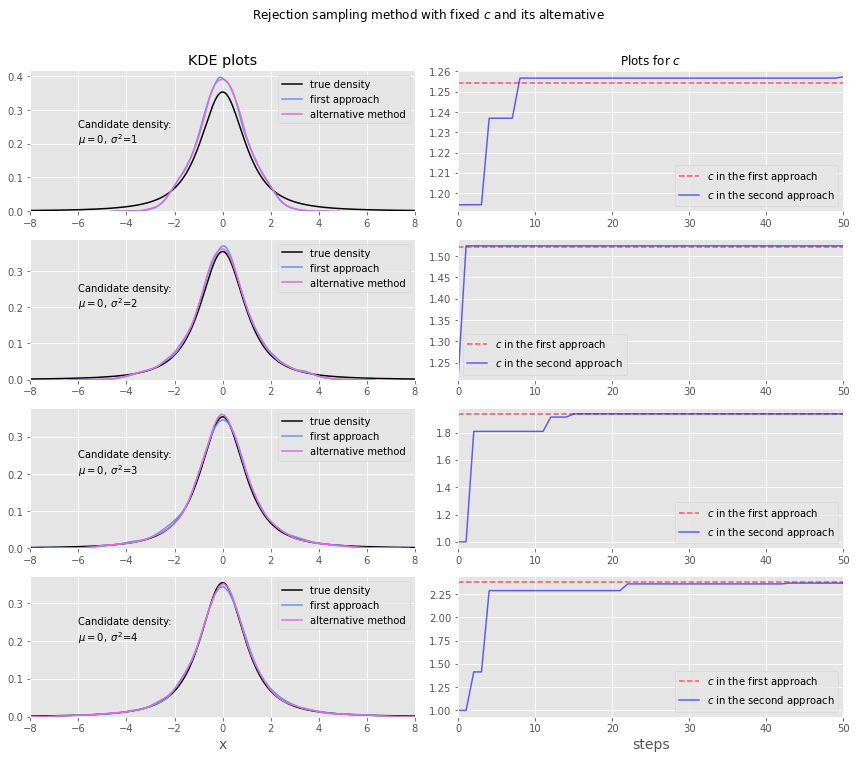

In [73]:
# Experiments
mu = 0   
num_sim = 40000
c0 = 1
var_vec = [1, 2, 3, 4]

Rejection_Comparison_Plots(mu, var_vec, c0, num_sim)

We can discuss on above results. As we know from rejection method, the unconditional probability of acceptance at each steps is $1/c$. For cases $\sigma^2 = 1$ and $\sigma^2 = 2$ , we have ( at every step or after some steps depending on the approach ) $c \approx 1.25$ and $c \approx 1.5$ respectively, so the probability of acceptance is high ( about $0.8$ and $0.66$ respectively ). This means, in each case, samples from normal distribution are accepted with high probabilty and therefore the accuracy has decreased. On the other hand for cases $\sigma^2=3$ or $\sigma^2=4$, the probability of acceptance becomes lower ( but not very low ) after some steps. In these cases we see a good fit for true density after $40000$ simulations.

In the last cell I have compared rejection sampling method where I used $c = \sup \frac{f(x)}{g(x)}$ and Monte-Carlo Markov chain method which is random walk Metropolis-Hastings method. For rejection sampling method, I have chosen normal density with $\mu=0$ and $\sigma^2=3$ as the candidate density and for MCMC method I have chosen $\delta=1$ for the parameter of the symmetric random walk, because these parameters produced the best results in the previous cells.

In [14]:
def MCMC_Rejection_Plots(x0, delta, mu, v, s:list):
    
    """It compares Monte-Carlo Narkov chain with rejection sampling method."""
    
    fig, ax = plt.subplots(len(s), figsize=(10,10))
    for i, num_samples in enumerate(s):
        first_mathod = Markov_Monte_Carlo(x0, delta, num_samples)
        [c, second_method] = Rejection_Sampling1(mu, np.sqrt(v), num_samples)
        x = np.linspace(-8,8,num_samples) 
        ax[i].plot(x, t.pdf(x,2), label='1', color='black')
        sns.kdeplot(first_mathod, label='1', color='cornflowerblue', ax=ax[i])
        sns.kdeplot(second_method, label='2', color='orchid', ax=ax[i])
        ax[i].legend(['true density','MCMC','rejection sampling'], fontsize=10)
        ax[i].text(-6,0.25,'number of simulations={}'.format(num_samples), fontsize=12)
        ax[i].set_ylabel('KDE', fontsize=14)
        ax[i].set_xlim([-8,8])
        plt.suptitle('Comparison between MCMC and rejection sampling,\n for MCMC:'\
                    r' $\delta=1$ and for rejection sampling: $\mu=0,\,\sigma^2=3$'\
                     ' and $c\approx1.25$',y=1.05)
        plt.tight_layout()

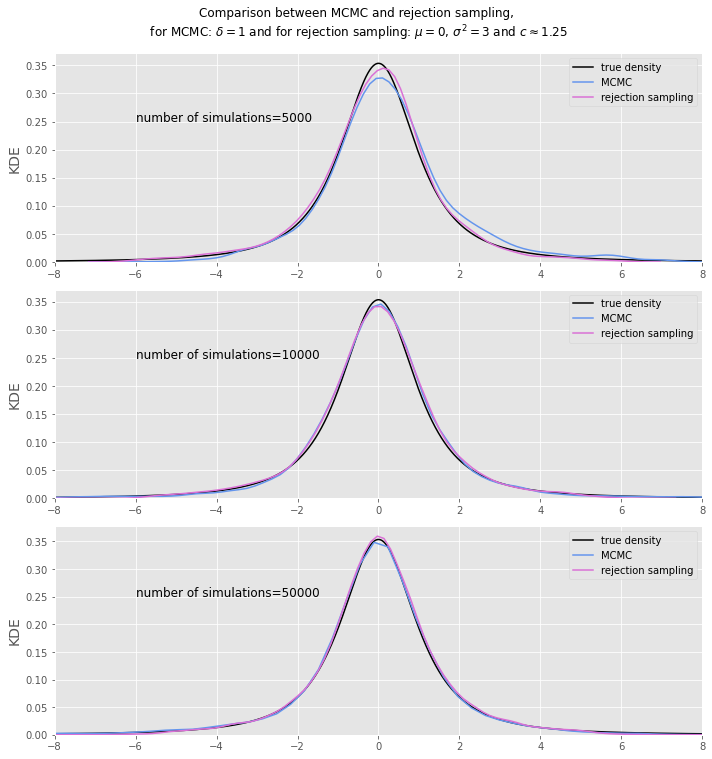

In [63]:
x0 = 0
delta = 1  
mu = 0   
v = 3
s = [5000, 10000, 50000]

MCMC_Rejection_Plots(x0, delta, mu, v, s)

We can see that with a good choice of paramaters for both methods, we have a close approximation after $50000$ simulations.